# Regime classification
This Notebook reads discharge observations available across Canada, collected by Shervan Gharari (USask) beforehand from Water Survey of Canada (WSC) Hydrological Database ([HYDAT](https://wateroffice.ec.gc.ca/index_e.html)). From these data, it classifies the basins' regimes using circular statistics to identify nival basins (basins with a snow-dominated regime).

Decisions:
- The nival regime definition (i.e., start and end doy & minimum regularity) was pre-defined by Paul Whitfield (USask) from expert knowledge of Canadian hydrology. See user-specified variables below.
- The water year definition: October 1st to September 30th. See user-specified variables below.
- For the peak over threshold calculations, the threshold used is the minimum value of all annual maxima.
- For the identification of nival basins with SWE stations, we require at least 30 years of overlap between the SWE & streamflow data. This threshold is set in order to keep basins where there is enough data to calibrate and forecast a forecasting model. See user-specified variables below.
- We could also select only basins with more recent data (e.g., >1960) to limit non-stationarity. Not implemented at this stage.
- Glacial basins are solely identified based on their peak DOY (from the 3 methods implemented).

# Modules, paths, variables & functions
Paths & variables are the only elements you should need to modify.

In [1]:
# Import required modules
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from shapely.geometry import Point
import warnings
import math
from scipy.stats import circmean

In [2]:
# Set required data paths
streamflow_obs_path = "/Users/lla068/Documents/data_driven_forecasting/data/basins_HYDAT/"  # streamflow observations directory
shp_path = "/Users/lla068/Documents/data_driven_forecasting/basins/"  # basin shapefiles directory
SWE_obs_path = "/Users/lla068/Documents/data_driven_forecasting/data/snow_obs_Canada/ECCC_CanSWE-CanEEN_1928-2020_v1_DONOTSHAREWITHANYONE.nc"  # CanSWE (1928,2020) SWE stations observations NetCDF compiled by ECCC (see: https://zenodo.org/record/4734372#.YUUXKi1b1mB). With additional private data from QC
RHBN_stations_path = "/Users/lla068/Documents/data_driven_forecasting/basins/RHBN_Metadata.xlsx"  # RHBN stations with limited human influence across Canada. See: https://www.canada.ca/en/environment-climate-change/services/water-overview/quantity/monitoring/survey/data-products-services/reference-hydrometric-basin-network.html

In [3]:
# Set user-specified variables
nival_start_doy_default = 91  # nival regime starting day of year
nival_end_doy_default = 213  # nival regime ending day of year
nival_regularity_threshold_default = 0.65  # nival regime minimum regularity threshold
testbasin_id = '05AA008'  # test basin ID taken from WSC HYDAT
testbasin_name = 'Crowsnest River at Frank'  # test basin name taken from WSC HYDAT
month_start_water_year_default, day_start_water_year_default = 10, 1  # water year start
month_end_water_year_default, day_end_water_year_default = 9, 30  # water year end
min_years_overlap_default = 30  # the minimum number of years of overlap between SWE and streamflow data we require
glacial_min_doy_default = 182  # 1st of July: the DOY passed which we assume that basins have a glacial regime. This is a conservative value to make sure we capture all basins with a glacial regime.

In [8]:
def extract_stations_in_basin(stations, basins, basin_id, buffer_km=0):
    
    """Extracts stations within a specified basin (with or without a buffer) and returns the extracted stations.
    
    Keyword arguments:
    ------------------
    - stations: Pandas GeoDataFrame of all stations available to subset from
    - basins: Pandas GeoDataFrame of all basin shapefiles available to subset from
    - basin_id: String of basin station ID
    - buffer_km: Positive value (in km) of buffer to add around basin shapefile (default=0; i.e., no buffer)
    
    Returns:
    --------
    - stations_in_basin: Pandas GeoDataFrame of all stations within the specified basin
    - basin_buffer: Zero if the default buffer is selected, otherwise buffer geometry for plotting
    
    """
    
    # Extract SWE stations within basin only (i.e., no buffer)
    if buffer_km == 0:
        basin_buffer = 0        
        mask = stations.within(basins.loc[basins['Station'] == basin_id].iloc[0].loc["geometry"])

    # Extract SWE stations within specified buffer of basin
    elif buffer_km > 0:
        
        # convert basin & stations geometry to a different CRS to be able to add a buffer in meters
        basin_crs_conversion = basins.loc[basins['Station'] == basin_id].to_crs(epsg=3763)
        stations_crs_conversion = stations.to_crs(epsg=3763)
        
        # add a buffer in meters around the basin
        buffer_m = buffer_km * 1000
        basin_buffer = basin_crs_conversion.buffer(buffer_m)
        mask = stations_crs_conversion.within(basin_buffer.iloc[0])
        
        # convert the buffer back to the original CRS for plotting
        basin_buffer = basin_buffer.to_crs(epsg=4326)

    stations_in_basin = stations.loc[mask].assign(basin=basin_id)
    
    return stations_in_basin, basin_buffer

In [9]:
def circular_stats(doy, year_length):
    
    """Calculates circular statistics. See: https://onlinelibrary.wiley.com/doi/abs/10.1002/hyp.7625
    
    Keyword arguments:
    ------------------
    - doy: Numpy array of day of year (doy) values for identified streamflow peaks
    - year_length: Numpy array of year length values for identified streamflow peaks
    
    Returns:
    --------
    - theta_rad: Numpy array of the angular values (in radians) that correspond to the doy
    - regularity: Dimensionless value indicating the spread of the data (ranges from 0: high spread to 1: low spread)
    
    """
    
    theta_rad = doy * ((2*math.pi)/year_length)
    x_coord = np.mean([math.cos(x) for x in theta_rad])
    y_coord = np.mean([math.sin(x) for x in theta_rad])
    regularity = math.sqrt(x_coord**2 + y_coord**2)
    
    return theta_rad, regularity

In [10]:
def polar_plot(theta_rad, regularity, flag, nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default, nival_regularity_threshold=nival_regularity_threshold_default):
    
    """Plots circular statistics on a polar plot for a single or multiple basins.
    
    Keyword arguments:
    ------------------
    - theta_rad: Numpy array of the angular values (in radians) that correspond to the doy
    - regularity: Dimensionless value indicating the spread of the data (ranges from 0: high spread to 1: low spread)
    - flag: Flag to indicate if a single (0) or multiple (1) basins should be plotted
    - nival_start_doy: Integer day of year (doy) of the start of the nival period (default=pre-defined at the top of the Notebook)
    - nival_end_doy: Integer day of year (doy) of the end of the nival period (default=pre-defined at the top of the Notebook)
    - nival_regularity_threshold: Float of the minimum regularity threshold allowed for basins to be categorized as being nival (default=pre-defined at the top of the Notebook)
    
    Returns:
    --------
    - A polar plot of circular statistics.
    
    """

    # Initialize the figure
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(polar=True)
    lines, labels = plt.thetagrids(np.arange(0,361,30),['1st Jan', '1st Feb', '1st Mar', '1st Apr', '1st May', '1st Jun', '1st Jul', '1st Aug', '1st Sep', '1st Oct', '1st Nov', '1st Dec'])
    ax.set_theta_zero_location('S')
    ax.set_theta_direction(-1)
    
    # Plot circular statistics for a single basin - i.e., individual events are shown
    if flag == 0:
        plt.plot(circmean(theta_rad), regularity, 'bo', label='circular statistics')
        plt.plot(theta_rad, [1.1]*len(theta_rad), 'ks', ms=5, label='events');
    
    # Plot circular statistics for multiple basins - i.e., individual events are not shown
    elif flag == 1:
        plt.plot(theta_rad, regularity, 'bo')
        
    # Add information on polar plot about pluvial & nival regimes
    nival_start = nival_start_doy * ((2*math.pi)/365)
    nival_end = nival_end_doy * ((2*math.pi)/365)
    plt.fill_between(np.linspace(nival_start, nival_end, 100), nival_regularity_threshold, 1, color='b', alpha=.2, label='nival')
    pluvial_start_1 = 274 * ((2*math.pi)/365)
    pluvial_end_1 = 365 * ((2*math.pi)/365)
    pluvial_start_2 = 0 * ((2*math.pi)/365)
    pluvial_end_2 = 30 * ((2*math.pi)/365)
    plt.fill_between(np.linspace(pluvial_start_1, pluvial_end_1, 100), 0.45, 1, color='g', alpha=.2, label='pluvial')
    plt.fill_between(np.linspace(pluvial_start_2, pluvial_end_2, 100), 0.45, 1, color='g', alpha=.2)

    plt.legend(loc=(1,1));

In [26]:
def basins_maps(basins, method, title_end, colours_column, nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default):
    
    """Plots two maps of basins provided, one that shows the basins' shapes & one that shows the basins' outlets.
    
    Keyword arguments:
    ------------------
    - basins: Pandas GeoDataFrame of all basin shapefiles available to subset from
    - method: String of the metric used to identify streamflow peaks (shown on maps' title)
    - title_end: String of a note to add at the end of the maps' title (e.g., referring to the basins shown)
    - colours_column: String of the column label to be used for colouring the maps
    - nival_start_doy: Integer day of year (doy) of the start of the nival period (default=pre-defined at the top of the Notebook)
    - nival_end_doy: Integer day of year (doy) of the end of the nival period (default=pre-defined at the top of the Notebook)
    
    Returns:
    --------
    - Two maps of basins.
    
    """

    # Plot map of basins' shapes
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
    basins.sort_values(by=['Shp_Area'], ascending=False).plot(ax=ax, column=colours_column, cmap=plt.cm.viridis, vmin=nival_start_doy, vmax=nival_end_doy_default, legend=True)  # sorting the basins by area so that smaller basins aren't hidden under larger basins that encompass them
    minx, miny, maxx, maxy = np.nanmin(basins.geometry.bounds.minx),np.nanmin(basins.geometry.bounds.miny),np.nanmax(basins.geometry.bounds.maxx),np.nanmax(basins.geometry.bounds.maxy)
    ax.set_xlim(minx-2, maxx+2)
    ax.set_ylim(miny-2, maxy+2)
    plt.text(maxx+9, maxy+4, 'DOY', fontsize=12)
    plt.title('Nival basins ('+method+')'+title_end)
    plt.text(minx,miny,'Total basins='+str(len(basins.index)));

    # Plot map of basins' outlets
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
    sc = plt.scatter(basins.outlet_lon.values, basins.outlet_lat.values, c=basins[colours_column].values, cmap=plt.cm.viridis, vmin=nival_start_doy, vmax=nival_end_doy_default)
    plt.colorbar(sc)            
    ax.set_xlim(minx-2, maxx+2)
    ax.set_ylim(miny-2, maxy+2)
    plt.text(maxx+9, maxy+4, 'DOY',fontsize=12)
    plt.title('Nival basins ('+method+')'+title_end)
    plt.text(minx,miny,'Total basins='+str(len(basins.index)));

In [12]:
def streamflow_peaks_statistics(streamflow_data, flag):
    
    """Identifies the streamflow peaks for a given method (i.e., flag).
    
    Keyword arguments:
    ------------------
    - streamflow_data: Pandas DataFrame of the daily streamflow observations for a basin
    - flag: An integer of 1, 2 or 3 defining the method to be used for identifying streamflow peaks
      -> flag=1: streamflow annual maxima
      -> flag=2: peak over threshold (POT) where the threshold = minimum value of all annual maxima
      -> flag=3: annual centres of mass (i.e., doy where 1/2 of the total water year streamflow has passed through the river - see: https://journals.ametsoc.org/view/journals/clim/18/2/jcli-3272.1.xml)

    Returns:
    --------
    - streamflow_stats: Pandas DataFrame of the streamflow peaks statistics
    
    """
    
    # Calculate streamflow annual maxima - we need the annual maxima to calculate the POT
    if flag == 1 or flag == 2:
        streamflow_data_peaks = streamflow_data.groupby("water_year").Flow.max().dropna(axis=0)
        streamflow_data_peaks_doys = streamflow_data.groupby("water_year").Flow.idxmax(skipna=False).dropna(axis=0)
        streamflow_stats = pd.DataFrame(data=streamflow_data_peaks_doys.values, index=streamflow_data_peaks_doys.index, columns=["doy"])
        dates = pd.to_datetime([str(x)+"-01-01" for x in streamflow_stats.index.values], format='%Y-%m-%d')
        leap_years = dates.is_leap_year.astype(int)
        streamflow_stats['length_year'] = [366 if x == 1 else 365 for x in leap_years]
        streamflow_stats['annual_maxima'] = streamflow_data_peaks[streamflow_data_peaks_doys.index]
        
    # Calculate peak over threshold (POT)
    if flag == 2:
        threshold = streamflow_stats['annual_maxima'].min() # threshold = minimum value of all annual maxima
        streamflow_data_peaks = streamflow_data[streamflow_data.Flow>threshold]
        streamflow_stats = pd.DataFrame(data=streamflow_data_peaks).drop(columns=['Station_ID','time','lat','lon']).reset_index()
        dates = pd.to_datetime([str(x)+"-01-01" for x in streamflow_stats.year.values], format='%Y-%m-%d')
        leap_years = dates.is_leap_year.astype(int)
        streamflow_stats['length_year'] = [366 if x == 1 else 365 for x in leap_years]
        
    # Centre of mass - https://journals.ametsoc.org/view/journals/clim/18/2/jcli-3272.1.xml
    elif flag == 3:
        streamflow_data_peaks = []
        streamflow_data_peaks_doys = []
        water_years = []
        for wy in list(set(streamflow_data['water_year'].values)):
            streamflow_cumsum = streamflow_data[streamflow_data['water_year']==wy].Flow.cumsum(skipna=True)
            if streamflow_cumsum.isnull().values.any() == False:
                water_years.append(wy)
                mid_pt = streamflow_cumsum.values[-1]/2
                mid_pt_position = np.abs(streamflow_cumsum.values - mid_pt).argmin()
                centre_of_mass = streamflow_cumsum.iloc[mid_pt_position]
                streamflow_data_peaks.append(centre_of_mass)
                streamflow_data_peaks_doys.append(streamflow_cumsum[streamflow_cumsum==centre_of_mass].index.values[0])
            else:
                continue
        streamflow_stats = pd.DataFrame(data=streamflow_data_peaks_doys, index=np.arange(len(streamflow_data_peaks_doys)), columns=["doy"])
        dates = pd.to_datetime([str(x)+"-01-01" for x in water_years], format='%Y-%m-%d')
        leap_years = dates.is_leap_year.astype(int)
        streamflow_stats['length_year'] = [366 if x == 1 else 365 for x in leap_years]
        streamflow_stats['centre_of_mass'] = streamflow_data_peaks
        
    return streamflow_stats

In [13]:
def regime_classification(streamflow_obs_path, shp_path, start_water_year, flag):
    
    """Performs the regime classification for a given method (i.e., flag).
    
    Keyword arguments:
    ------------------
    - streamflow_obs_path: String of streamflow observations directory
    - shp_path: String of basin shapefiles directory
    - start_water_year: Tuple with (month, day) of the water year starting date
    - flag: An integer of 1, 2 or 3 defining the method to be used for identifying streamflow peaks
      -> flag=1: streamflow annual maxima
      -> flag=2: peak over threshold (POT) where the threshold = minimum value of all annual maxima
      -> flag=3: annual centres of mass (i.e., doy where 1/2 of the total water year streamflow has passed through the river - see: https://journals.ametsoc.org/view/journals/clim/18/2/jcli-3272.1.xml)

    Returns:
    --------
    - basins_regimes: Pandas GeoDataFrame containing station information (e.g., outlet lat, lon and ID) & circular statistics for all stations available from WSC HYDAT
    
    """

    # Set empty lists to store information on stations & their circular statistics
    id_stations = []
    theta_rad_stations = []
    regularity_stations = []
    doy_stations = []
    lat_stations = []
    lon_stations = []

    # Set counter to merge all shapefiles into one Pandas GeoDataFrame
    count = 0

    # Loop over Canadian regions (i.e., WSC HYDAT Canadian basins are grouped into different regions from 1 to 11)
    for r in ['01','02','03','04','05','06','07','08','09','10','11']:
        
        # open streamflow observations data
        streamflow_data_ds = xr.open_dataset(streamflow_obs_path+"HYDAT_"+r+".nc")
        
        # open basin shapefiles
        basins_shp = gpd.read_file(shp_path+r+".shp")
        
        count += 1
        
        # append shapefiles
        if count == 1:
            merged_basins_shp = basins_shp
        else:
            merged_basins_shp = merged_basins_shp.append(basins_shp)

        # loop over stations with streamflow data within the region
        for s in streamflow_data_ds.Station_ID.values:

            # check that the station has a corresponding basin shapefile  
            if s in basins_shp.Station.values:
                            
                # read streamflow observations as Pandas DataFrame
                streamflow_data_da = streamflow_data_ds.where(streamflow_data_ds.Station_ID==s, drop=True).Flow
                streamflow_data_da = streamflow_data_da.set_index({"Station_ID":"Station_ID"})
                streamflow_data_da = streamflow_data_da.rename({"n":'Station_ID'})
                streamflow_data_df = streamflow_data_da.to_dataframe()
                streamflow_data_df.reset_index(inplace=True)
                streamflow_data_df['year'] = streamflow_data_df.time.map(lambda x: x.year)
                streamflow_data_df['doy'] = streamflow_data_df.time.map(lambda x: x.dayofyear)
                streamflow_data_df = streamflow_data_df.set_index('doy')
                
                # add a water year column
                water_year = []
                for i in pd.DatetimeIndex(streamflow_data_df.time.values):
                    if (i.month == start_water_year[0] and i.day >= start_water_year[1]) or (i.month > start_water_year[0]):
                        water_year.append(i.year + 1)
                    else:
                        water_year.append(i.year)
                streamflow_data_df['water_year'] = water_year
                
                # calculate the basin's streamflow statistics for the chosen method
                streamflow_stats = streamflow_peaks_statistics(streamflow_data_df, flag)
                
                # calculate the basin's circular statistics
                if streamflow_stats.empty == False:                    
                    theta_rad, regularity = circular_stats(streamflow_stats.doy.values, streamflow_stats.length_year.values)
                    
                    # save the circular statistics & basin's information
                    lat_stations.append(streamflow_data_df.lat.values[0])
                    lon_stations.append(streamflow_data_df.lon.values[0])
                    id_stations.append(s)
                    theta_rad_stations.append(circmean(theta_rad))
                    regularity_stations.append(regularity)
                    doy_stations.append(circmean(streamflow_stats.doy.values, high=366, low=1))
        
    # Create Pandas DataFrame to store all basins' circular statistics
    regimes_data = pd.DataFrame(data=np.column_stack((lat_stations, lon_stations, theta_rad_stations, regularity_stations, doy_stations)), index=id_stations, columns=["outlet_lat","outlet_lon","theta_rad","regularity","doy"])

    # Combine the basins' shapefiles Pandas GeoDataFrame with the regime classification information
    basins_regimes = merged_basins_shp.set_index('Station').merge(regimes_data, left_index=True, right_index=True, how='outer')
    
    return basins_regimes

In [14]:
# Function to plot cumulative hydrographs for all identified nival basins
def cumulative_hydrographs(basins, streamflow_obs_path, flag=0):
    
    """Plots normalized cumulative climatological hydrographs for the provided basins.
    
    Keyword arguments:
    ------------------
    - basins: Pandas GeoDataFrame of all basins to plot
    - streamflow_obs_path: String of streamflow observations directory
    - flag: An integer of 0 or 1, where 1 indicates that glacial basins should be plotted using a distinctive colour (default=0)

    Returns:
    --------
    - A plot of all basins' cumulative climatological hydrographs.
    
    """
    
    # We expect to see RuntimeWarnings in this block due to missing values
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # loop over Canadian regions (i.e., WSC HYDAT Canadian basins are grouped into different regions from 1 to 11)
        for r in ['01','02','03','04','05','06','07','08','09','10','11']:

            # open streamflow observations data
            streamflow_data_ds = xr.open_dataset(streamflow_obs_path+"HYDAT_"+r+".nc")
            streamflow_data_ds = streamflow_data_ds.set_index({"Station_ID":"Station_ID"})
            streamflow_data_ds = streamflow_data_ds.rename({"n":'Station_ID'})

            # extract all stations for plotting that fall within the region
            stations_idx_inregion = [x for x in basins.index.values if x.startswith(r)]

            # loop over the region's stations
            for s in stations_idx_inregion:

                # calculate the climatological mean flow for each DOY
                doy_mean = streamflow_data_ds.where(streamflow_data_ds.Station_ID==s, drop=True).Flow.groupby("time.dayofyear").mean(skipna=True)

                # calculate the normalized cumulative sum over this climatological timeseries - we normalize so that all basins hydrographs can be plotted on a single plot 
                cumsum_norm = doy_mean.cumsum() / doy_mean.cumsum().values[0][-1]
                
                # differentiating color of basins with nival and glacial regimes
                if flag == 1:
                    if basins.loc[s].regime == 'glacial':
                        color='r'
                        alpha=1
                    else:
                        color='b'
                        alpha=.1
                elif flag == 0:
                    color='b'
                    alpha=.3
                
                # plotting
                cumsum_norm.plot(color=color, alpha=alpha)

    plt.title('')
    plt.ylabel('Climatological mean cumulative streamflow [normalized]')
    plt.xlabel('DOY')
    
    if flag == 1:
        plt.plot([np.nan], [np.nan], color='b', alpha=.1, label='nival basins')
        plt.plot([np.nan], [np.nan], color='r', alpha=1, label='glacial basins')
        plt.legend()
    ;  

# Regime classification

## For a test basin
Let's go over the regime classification for a test basin (specified at the top of the Notebook) to see how it works.

In [16]:
# Read the station daily streamflow data as a DataArray 
streamflow_file = xr.open_dataset(streamflow_obs_path+"HYDAT_"+testbasin_id[:2]+".nc")
streamflow_data_da = streamflow_file.where(streamflow_file.Station_ID==testbasin_id, drop=True).Flow #because Station_ID not indexed
streamflow_data_da = streamflow_data_da.set_index({"Station_ID":"Station_ID"})
streamflow_data_da = streamflow_data_da.rename({"n":'Station_ID'})

display(streamflow_data_da)

<xarray.DataArray 'Flow' (Station_ID: 1, time: 62092)>
array([[nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time        (time) datetime64[ns] 1850-01-01 1850-01-02 ... 2020-01-01
    lat         (Station_ID) float64 49.6
    lon         (Station_ID) float64 -114.4
  * Station_ID  (Station_ID) object '05AA008'
Attributes:
    long_name:  Daily flow
    units:      m**3 s**-1

In [17]:
# Re-organize data with day of year (doy) and water years information

# transform the DataArray into a Pandas DataFrame for data manipulations
streamflow_data_df = streamflow_data_da.to_dataframe()

# reset index to set doy as a new index
streamflow_data_df.reset_index(inplace=True)

# add a new column for the years
streamflow_data_df['year'] = streamflow_data_df.time.map(lambda x: x.year)

# loop over the data years to create a new column with water years
water_year = []
for i in pd.DatetimeIndex(streamflow_data_df.time.values):
    if (i.month == month_start_water_year_default and i.day >= day_start_water_year_default) or (i.month > month_start_water_year_default):
        water_year.append(i.year + 1)
    else:
        water_year.append(i.year)
streamflow_data_df['water_year'] = water_year

# create a new column with doy and set as DataFrame index
streamflow_data_df['doy'] = streamflow_data_df.time.map(lambda x: x.dayofyear)
streamflow_data_df = streamflow_data_df.set_index('doy')

display(streamflow_data_df)

,Station_ID,time,lat,lon,Flow,year,water_year
doy,,,,,,,
1,05AA008,1850-01-01,49.597321,-114.410637,NaN,1850,1850
2,05AA008,1850-01-02,49.597321,-114.410637,NaN,1850,1850
3,05AA008,1850-01-03,49.597321,-114.410637,NaN,1850,1850
4,05AA008,1850-01-04,49.597321,-114.410637,NaN,1850,1850
5,05AA008,1850-01-05,49.597321,-114.410637,NaN,1850,1850
...,...,...,...,...,...,...,...
362,05AA008,2019-12-28,49.597321,-114.410637,NaN,2019,2020
363,05AA008,2019-12-29,49.597321,-114.410637,NaN,2019,2020
364,05AA008,2019-12-30,49.597321,-114.410637,NaN,2019,2020


### Streamflow statistics
Below, we calculate 3 streamflow statistics that can be used for peak streamflow events identification: streamflow annual maxima, peaks over threshold (POT) & centre of mass. The reason behind calculating all 3 statistics is that none of these are fully reliable. Hence, we use a combination of all 3.

,doy,length_year,annual_maxima
water_year,,,
1912,168.0,366,20.1
1913,149.0,365,25.1
1914,123.0,365,17.4
1915,122.0,365,34.8
1916,172.0,366,47.6


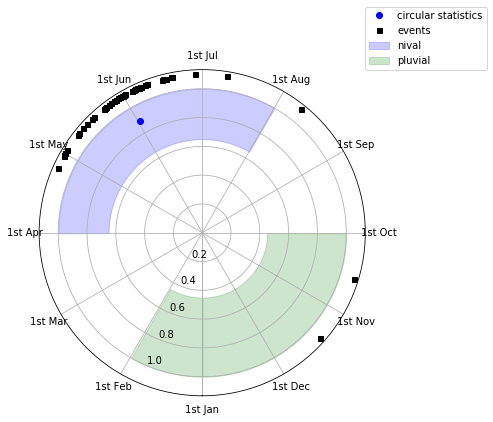

In [18]:
# Calculate streamflow annual maxima
streamflow_stats_annualmax = streamflow_peaks_statistics(streamflow_data_df, flag=1)

display(streamflow_stats_annualmax.head())

# Create polar plot
theta_rad_annualmax, regularity_annualmax = circular_stats(streamflow_stats_annualmax.doy.values, streamflow_stats_annualmax.length_year.values)
polar_plot(theta_rad_annualmax, regularity_annualmax, flag=0, nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default, nival_regularity_threshold=nival_regularity_threshold_default)

,doy,Flow,year,water_year,length_year
0,280,7.5,1910,1911,365
1,281,7.5,1910,1911,365
2,282,7.5,1910,1911,365
3,283,7.5,1910,1911,365
4,284,7.5,1910,1911,365


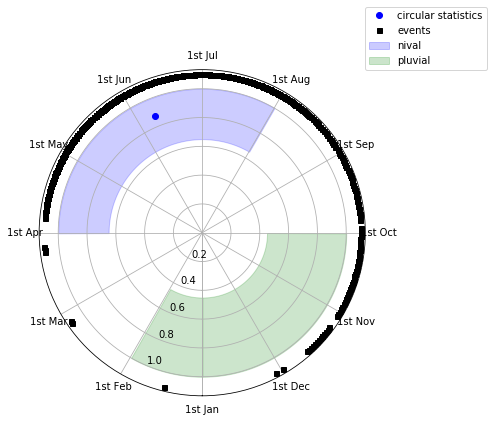

In [19]:
# Calculate streamflow POT
streamflow_stats_POT = streamflow_peaks_statistics(streamflow_data_df, flag=2)

display(streamflow_stats_POT.head())

# Create polar plot
theta_rad_POT, regularity_POT = circular_stats(streamflow_stats_POT.doy.values, streamflow_stats_POT.length_year.values)
polar_plot(theta_rad_POT, regularity_POT, flag=0, nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default, nival_regularity_threshold=nival_regularity_threshold_default)

,doy,length_year,centre_of_mass
0,152,366,852.570
1,152,365,937.835
2,143,365,881.951
3,138,365,1088.740
4,164,366,1287.004


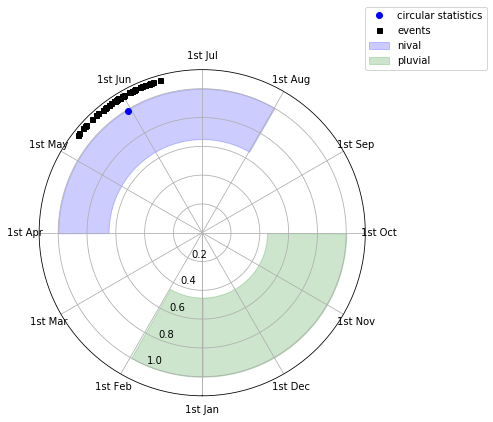

In [20]:
# Calculate streamflow centre of mass (COM)
streamflow_stats_COM = streamflow_peaks_statistics(streamflow_data_df, flag=3)

display(streamflow_stats_COM.head())

# Create polar plot
theta_rad_COM, regularity_COM = circular_stats(streamflow_stats_COM.doy.values, streamflow_stats_COM.length_year.values)
polar_plot(theta_rad_COM, regularity_COM, flag=0, nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default, nival_regularity_threshold=nival_regularity_threshold_default)

## For all basins
Now that we know how the regime classification works, let's run the regime classification for all basins where we have streamflow observations. But first for context, we plot maps of all basins with streamflow observations available in the dataset we are using.

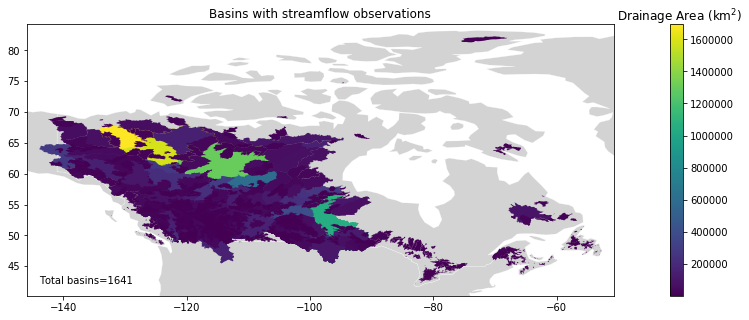

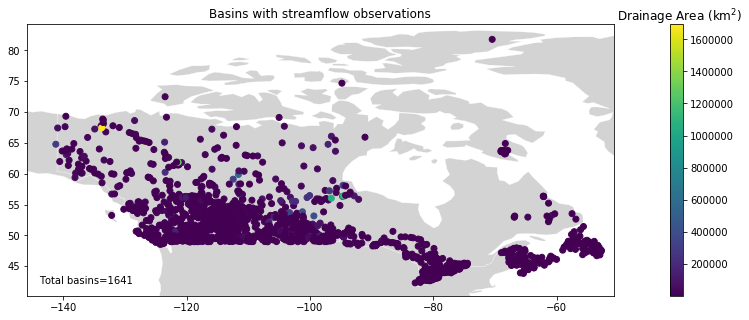

In [80]:
# Maps of all basins with streamflow observations available in the dataset 

# Set counter to merge all shapefiles into one Pandas GeoDataFrame
count = 0

# Loop over Canadian regions (i.e., WSC HYDAT Canadian basins are grouped into different regions from 1 to 11)
for r in ['01','02','03','04','05','06','07','08','09','10','11']:

    # open streamflow observations data
    streamflow_data_ds = xr.open_dataset(streamflow_obs_path+"HYDAT_"+r+".nc")

    # open basin shapefiles
    basins_shp = gpd.read_file(shp_path+r+".shp")

    # extract list of basins which are both in the streamflow observations dataset and in the basins shapefiles
    basins_to_keep = set.intersection(set(streamflow_data_ds.Station_ID.data), set(basins_shp['Station'].values))

    # extract only basins shapefiles with streamflow data
    basins_with_data_shp = basins_shp[basins_shp['Station'].isin(list(basins_to_keep))]
    
    # read streamflow observations as Pandas DataFrame
    streamflow_data_da = streamflow_data_ds.set_index({"Station_ID":"Station_ID"})
    streamflow_data_da = streamflow_data_da.rename({"n":'Station_ID'})
    streamflow_data_df = streamflow_data_da.Station_ID.to_dataframe()
    
    # add streamflow observation station lat & lon to basins shapefiles dataframe
    basins_with_data_shp['outlet_lon'] = streamflow_data_df[streamflow_data_df['Station_ID'].isin(list(basins_to_keep))].lon.values
    basins_with_data_shp['outlet_lat'] = streamflow_data_df[streamflow_data_df['Station_ID'].isin(list(basins_to_keep))].lat.values

    count += 1

    # append shapefiles
    if count == 1:
        merged_basins_shp = basins_with_data_shp
    else:
        merged_basins_shp = merged_basins_shp.append(basins_with_data_shp)
        
# Plot map of basins' shapes
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
merged_basins_shp.sort_values(by=['Shp_Area'], ascending=False).plot(ax=ax, column='Shp_Area', cmap=plt.cm.viridis, legend=True)  # sorting the basins by area so that smaller basins aren't hidden under larger basins that encompass them
minx, miny, maxx, maxy = np.nanmin(merged_basins_shp.geometry.bounds.minx),np.nanmin(merged_basins_shp.geometry.bounds.miny),np.nanmax(merged_basins_shp.geometry.bounds.maxx),np.nanmax(merged_basins_shp.geometry.bounds.maxy)
ax.set_xlim(minx-2, maxx+2)
ax.set_ylim(miny-2, maxy+2)
plt.text(maxx+2.5, maxy+2.5, 'Drainage Area (km$^2$)', fontsize=12)
plt.title('Basins with streamflow observations')
plt.text(minx,miny,'Total basins='+str(len(merged_basins_shp.index)));

# Plot map of basins' outlets
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
sc = plt.scatter(merged_basins_shp.outlet_lon.values, merged_basins_shp.outlet_lat.values, c=merged_basins_shp['Shp_Area'].values, cmap=plt.cm.viridis)
plt.colorbar(sc)            
ax.set_xlim(minx-2, maxx+2)
ax.set_ylim(miny-2, maxy+2)
plt.text(maxx+2.5, maxy+2.5, 'Drainage Area (km$^2$)',fontsize=12)
plt.title('Basins with streamflow observations')
plt.text(minx,miny,'Total basins='+str(len(merged_basins_shp.index)));

### Based on streamflow annual maxima

In [21]:
# Regime classification from streamflow annual maxima - this takes a while to run as it loops over all basins
basins_regimes_annualmax = regime_classification(streamflow_obs_path, shp_path, start_water_year=(month_start_water_year_default, day_start_water_year_default), flag=1)

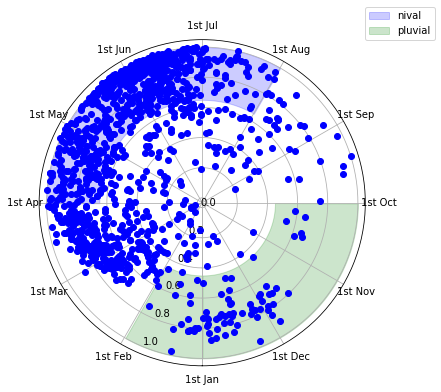

In [31]:
# Create polar plot
polar_plot(basins_regimes_annualmax.theta_rad.dropna().values, basins_regimes_annualmax.regularity.dropna().values, flag=1, nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default, nival_regularity_threshold=nival_regularity_threshold_default)

In [24]:
# Identify only nival basins - i.e., in blue shaded area on the polar plot above
nival_basins_annualmax = basins_regimes_annualmax[(basins_regimes_annualmax["doy"] >= nival_start_doy_default) & (basins_regimes_annualmax["doy"] <= nival_end_doy_default) & (basins_regimes_annualmax["regularity"] >= nival_regularity_threshold_default)]

print("Based on streamflow annual maxima: There are "+str(len(nival_basins_annualmax.index))+" nival basins")

Based on streamflow annual maxima: There are 728 nival basins


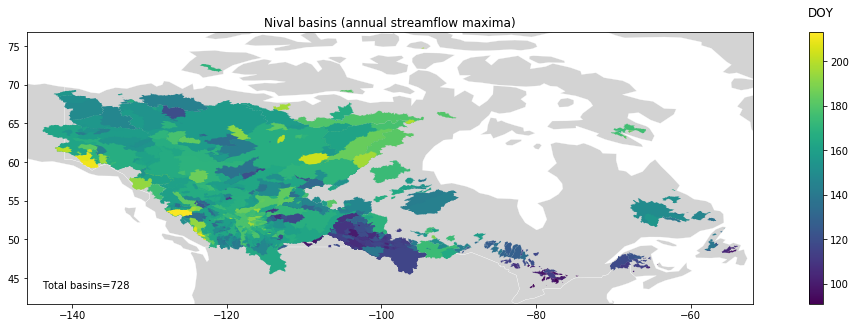

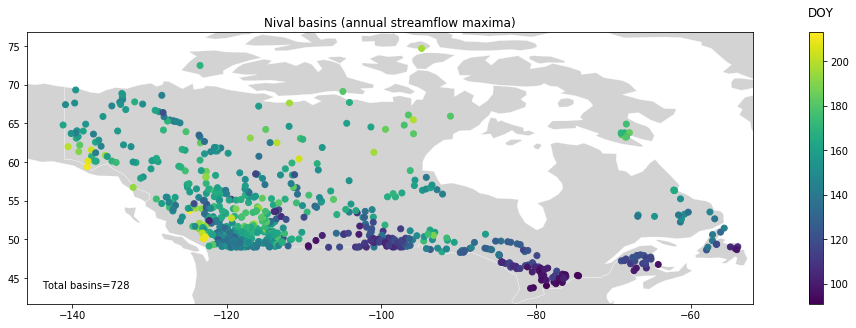

In [27]:
# Plot nival basins on map
basins_maps(nival_basins_annualmax, method='annual streamflow maxima', title_end='', colours_column='doy', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

### Based on streamflow POT

In [32]:
# Regime classification from POT - this takes a while to run as it loops over all basins
basins_regimes_POT = regime_classification(streamflow_obs_path, shp_path, start_water_year=(month_start_water_year_default, day_start_water_year_default), flag=2)

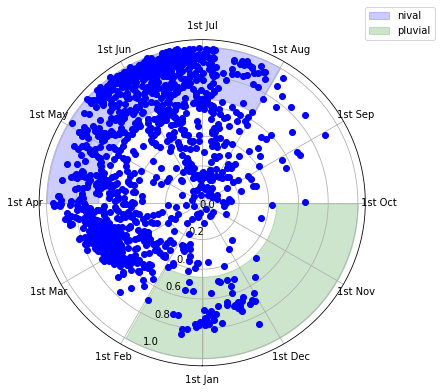

In [35]:
# Create polar plot
polar_plot(basins_regimes_POT.theta_rad.dropna().values, basins_regimes_POT.regularity.dropna().values, flag=1, nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default, nival_regularity_threshold=nival_regularity_threshold_default)

In [36]:
# Identify only nival basins - i.e., in blue shaded area on the polar plot above
nival_basins_POT = basins_regimes_POT[(basins_regimes_POT["doy"] >= nival_start_doy_default) & (basins_regimes_POT["doy"] <= nival_end_doy_default) & (basins_regimes_POT["regularity"] >= nival_regularity_threshold_default)]

print("Based on streamflow POT: There are "+str(len(nival_basins_POT.index))+" nival basins")

Based on streamflow POT: There are 589 nival basins


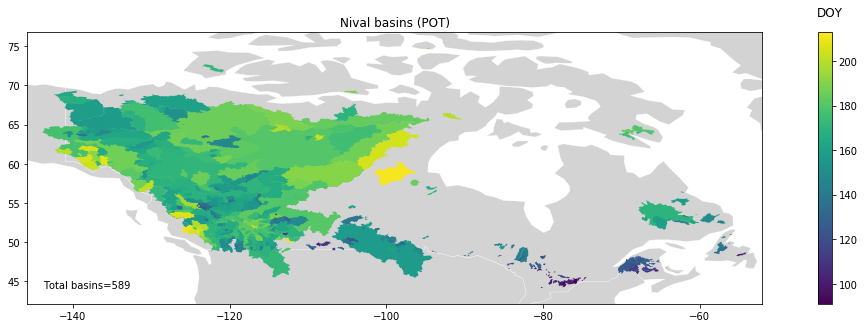

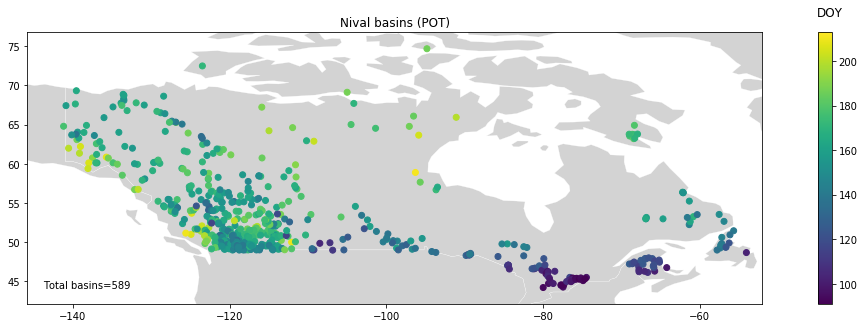

In [37]:
# Plot nival basins on map
basins_maps(nival_basins_POT, method='POT', title_end='', colours_column='doy', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

### Based on streamflow COM

In [39]:
# Regime classification from COM - this takes a while to run as it loops over all basins
basins_regimes_COM = regime_classification(streamflow_obs_path, shp_path, start_water_year=(month_start_water_year_default, day_start_water_year_default), flag=3)

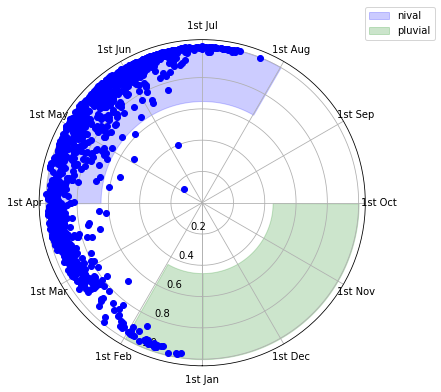

In [41]:
# Create polar plot
polar_plot(basins_regimes_COM.theta_rad.dropna().values, basins_regimes_COM.regularity.dropna().values, flag=1, nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default, nival_regularity_threshold=nival_regularity_threshold_default)

In [42]:
# Identify only nival basins - i.e., in blue shaded area on the polar plot above
nival_basins_COM = basins_regimes_COM[(basins_regimes_COM["doy"] >= nival_start_doy_default) & (basins_regimes_COM["doy"] <= nival_end_doy_default) & (basins_regimes_COM["regularity"] >= nival_regularity_threshold_default)]

print("Based on streamflow COM: There are "+str(len(nival_basins_COM.index))+" nival basins")

Based on streamflow COM: There are 865 nival basins


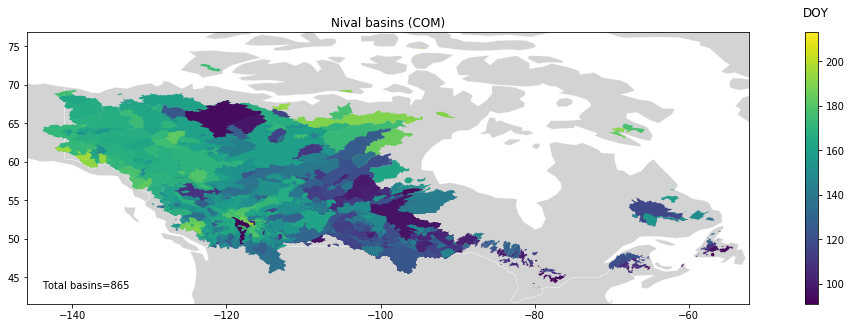

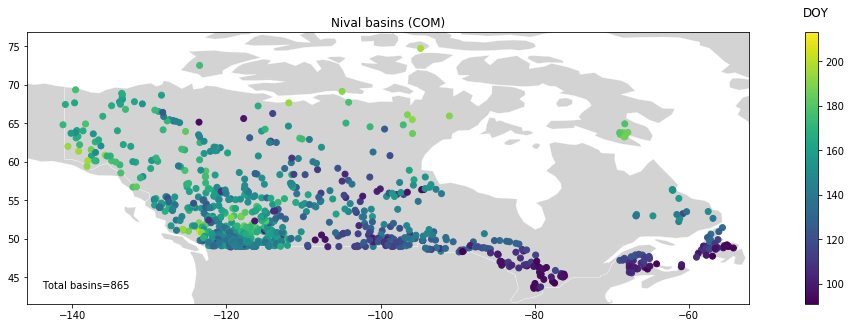

In [43]:
# Plot nival basins on map
basins_maps(nival_basins_COM, method='COM', title_end='', colours_column='doy', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

In [44]:
# Store intermediate datasets so we don't have to re-run this again
%store nival_basins_annualmax
%store nival_basins_POT
%store nival_basins_COM

Stored 'nival_basins_annualmax' (GeoDataFrame)
Stored 'nival_basins_POT' (GeoDataFrame)
Stored 'nival_basins_COM' (GeoDataFrame)


# Sub-selection of basins with SWE stations & limited regulation

## Sub-select nival basins with SWE stations
Now that we have identified all basins with a nival regime, we need to find out which of these have at least 1 SWE station with at least X years (the number of years is pre-defined at the top of the Notebook) of overlapping SWE and streamflow data.

In [45]:
# Identify basins with at least 1 SWE station - this takes a while to run as it loops over all basins

# read the SWE stations observations file - this automatically closes the dataset after use, necessary for memory reasons
with xr.open_dataset(SWE_obs_path) as ds:

    # re-organize the dataset as needed - we need to have time, station_id, lon, lat and station_name as coordinates and snw as variable
    SWE_stations_ds = ds.assign_coords({'lon':ds.lon, 'lat':ds.lat, 'station_name':ds.station_name}).snw.to_dataset()
    data = {'station_id': SWE_stations_ds.station_id.data, 
            'lon': SWE_stations_ds.lon.data, 
            'lat': SWE_stations_ds.lat.data} 
    df = pd.DataFrame(data)
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    crs = "EPSG:4326"
    SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    
# manually trigger loading of this dataset into memory and return it
SWE_stations_ds.load()
    
# set empty dictionary to store basins' info for overlapping SWE & streamflow data (e.g., number of overlapping years)
basins_with_swe_info = {}

# loop over Canadian regions (i.e., WSC HYDAT Canadian basins are grouped into different regions from 1 to 11)
for r in ['01','02','03','04','05','06','07','08','09','10','11']:

    # read streamflow observations as xarray DataSet
    streamflow_data_ds = xr.open_dataset(streamflow_obs_path+"HYDAT_"+r+".nc")
    streamflow_data_ds = streamflow_data_ds.set_index({"Station_ID":"Station_ID"})
    streamflow_data_ds = streamflow_data_ds.rename({"n":'Station_ID'})
    
    # open basin shapefiles
    basins_shp = gpd.read_file(shp_path+r+".shp")  
    
    # loop over stations with streamflow data within the region
    for s in streamflow_data_ds.Station_ID.values:

        # check that the station has a corresponding basin shapefile 
        if s in basins_shp.Station.values:

            # read streamflow observations for basin as xarray DataArray
            streamflow_data_da = streamflow_data_ds.where(streamflow_data_ds.Station_ID==s, drop=True).Flow

            # extract SWE stations in basin only
            SWE_stations_in_basin = extract_stations_in_basin(SWE_stations_gdf, basins_shp, s, buffer_km=0)[0]

            # if there is/are (a) station(s) within the basin we can proceed
            if SWE_stations_in_basin.empty == False:

                # transform the xarray DataArray to a Pandas DataFrame for data manipulations
                SWE_stations_df = SWE_stations_ds.sel(station_id = SWE_stations_in_basin["station_id"].values).to_dataframe()
                SWE_stations_df = SWE_stations_df.drop(columns=['lon','lat','station_name']).unstack()['snw'].T

                # calculate the annual max (averaged over all SWE stations), as a proxy for data availability for any given year
                SWE_annualmax = SWE_stations_df.groupby(SWE_stations_df.index.year).max()
                SWE_annualmax = SWE_annualmax.mean(axis=1)

                # calculate the streamflow annual maxima
                streamflow_data_df = streamflow_data_da.to_dataframe()
                streamflow_data_df.reset_index(inplace=True)
                streamflow_data_df['year'] = streamflow_data_df.time.map(lambda x: x.year)
                streamflow_data_df['doy'] = streamflow_data_df.time.map(lambda x: x.dayofyear)
                streamflow_data_df = streamflow_data_df.set_index('doy')
                streamflow_annualmax = streamflow_data_df.groupby("year").Flow.max().dropna(axis=0)

                # combine streamflow & SWE timeseries and remove any years with missing data
                SWE_Q_timeseries = pd.DataFrame(data=SWE_annualmax.copy(), index=SWE_annualmax.index.values, columns=["SWE"])
                SWE_Q_timeseries['Flow'] = streamflow_annualmax
                SWE_Q_timeseries = SWE_Q_timeseries.dropna(axis=0, how='any')
                
                # if there is more than 1 year of overlapping data, save basin overlapping data information
                if len(SWE_Q_timeseries.index) > 0:
                    basins_with_swe_info[s] = [SWE_Q_timeseries.index.values[0], SWE_Q_timeseries.index.values[-1], len(SWE_Q_timeseries.index)]

                else:
                    continue
            
            else:
                continue
                
# Save basins with at least 1 SWE station to a Pandas DataFrame
basins_with_swe = pd.DataFrame.from_dict(basins_with_swe_info, orient='index', columns=['start_year', 'end_year', 'total_years'])

In [46]:
# Identify basins with at least 1 SWE station that meet the data overlap requirements
# i.e., at least X years of overlapping data (see pre-defined variables at the top of the Notebook)
selected_basins_with_swe = basins_with_swe[basins_with_swe.total_years >= min_years_overlap_default]

display(selected_basins_with_swe)

,start_year,end_year,total_years
01AD002,1955,2014,60
01AD003,1958,2015,58
01AF002,1955,2015,61
01AF007,1982,2014,33
01AH002,1956,2013,57
...,...,...,...
10LC014,1972,2015,44
10MA001,1976,2014,33
10MC002,1976,2015,39
11AB082,1962,2015,48


In [47]:
# Store intermediate datasets so we don't have to re-run this again
%store basins_with_swe

Stored 'basins_with_swe' (DataFrame)


### Based on streamflow annual maxima
We can now sub-select nival basins identified based on streamflow annual maxima that meet the SWE stations criteria.

In [48]:
# Extract only nival basins with SWE observations
nival_basins_annualmax_withswe = nival_basins_annualmax.reindex(index=selected_basins_with_swe.index.values).dropna(axis=0, how='all')

print("Based on streamflow annual maxima: There are "+str(len(nival_basins_annualmax_withswe.index))+" nival basins with SWE observations")

Based on streamflow annual maxima: There are 240 nival basins with SWE observations


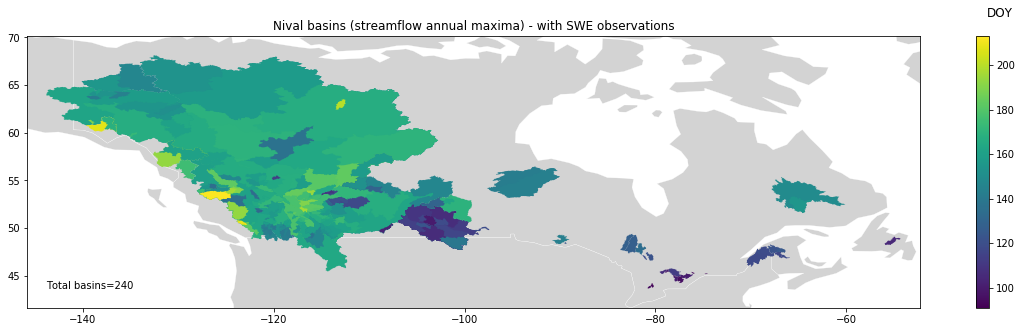

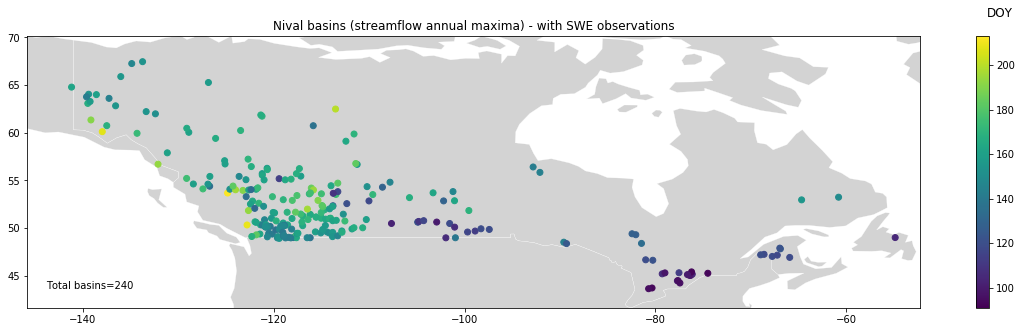

In [49]:
# Plot nival basins on map
basins_maps(nival_basins_annualmax_withswe, method='streamflow annual maxima', title_end=' - with SWE observations', colours_column='doy', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

### Based on streamflow POT
We can now sub-select nival basins identified based on streamflow POT that meet the SWE stations criteria.

In [50]:
# Extract only nival basins with SWE observations
nival_basins_POT_withswe = nival_basins_POT.reindex(index=selected_basins_with_swe.index.values).dropna(axis=0, how='all')

print("Based on streamflow POT: There are "+str(len(nival_basins_POT_withswe.index))+" nival basins with SWE observations")

Based on streamflow POT: There are 200 nival basins with SWE observations


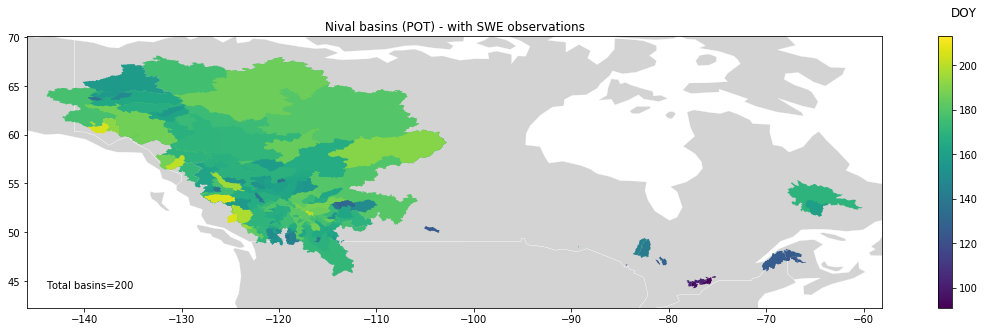

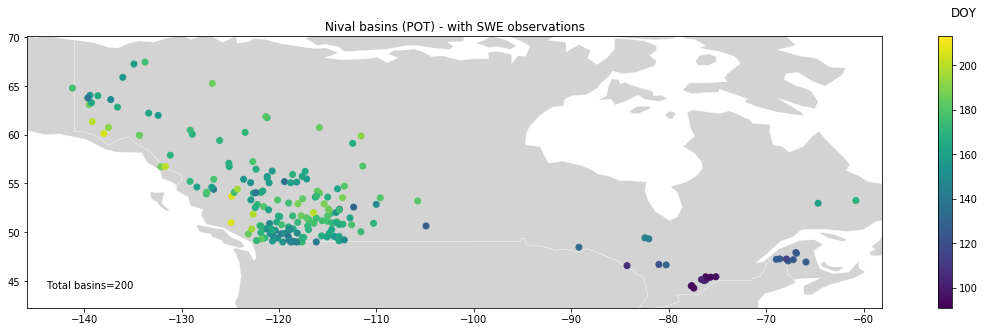

In [51]:
# Plot nival basins on map
basins_maps(nival_basins_POT_withswe, method='POT', title_end=' - with SWE observations', colours_column='doy', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

### Based on streamflow COM
We can now sub-select nival basins identified based on streamflow COM that meet the SWE stations criteria.

In [52]:
# Extract only nival basins with SWE observations
nival_basins_COM_withswe = nival_basins_COM.reindex(index=selected_basins_with_swe.index.values).dropna(axis=0, how='all')

print("Based on streamflow COM: There are "+str(len(nival_basins_COM_withswe.index))+" nival basins with SWE observations")

Based on streamflow COM: There are 274 nival basins with SWE observations


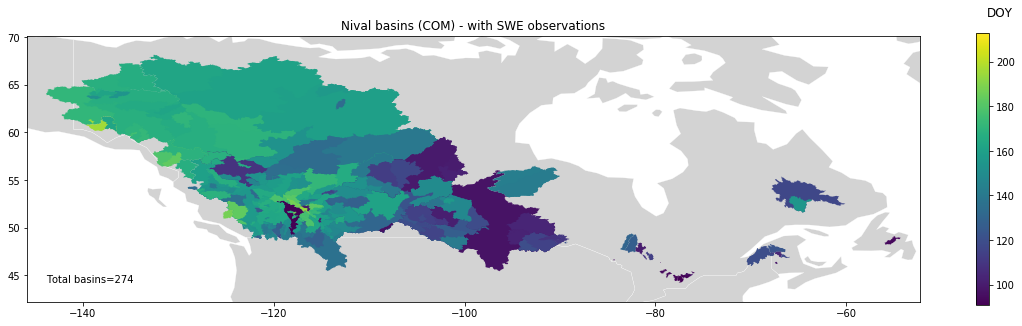

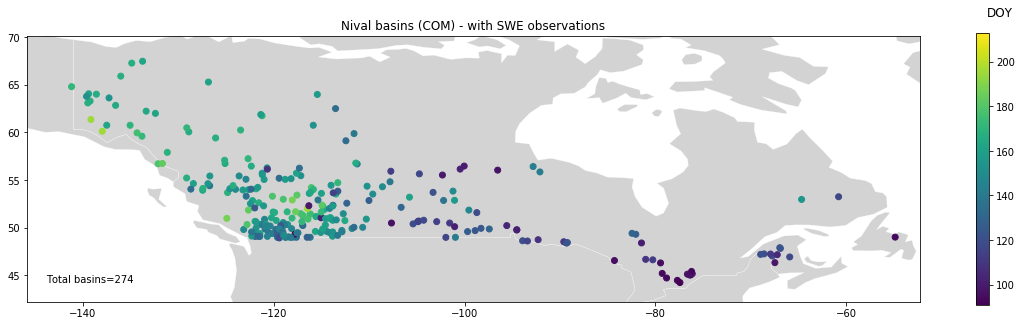

In [53]:
# Plot nival basins on map
basins_maps(nival_basins_COM_withswe, method='COM', title_end=' - with SWE observations', colours_column='doy', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

## Sub-select nival basins with limited regulation
We now identify basins with limited human influence, taken from the RHBN dataset defined in the paths at the top of the Notebook.

In [54]:
# Read metadata for RHBN stations with limited human influence across Canada
RHBN_stations = pd.read_excel(RHBN_stations_path, header=2, skiprows=[3])
RHBN_stations = RHBN_stations[RHBN_stations["Evaluation_Year"] == 2020]
display(RHBN_stations)

,STATION_NUMBER,Evaluation_Year,RHBN-N,DATA_TYPE,Yield,Ecoregion,Data.Quality,Years.C,Years.S,Watershed.Quality,Percent_Human.Impact,Percent.Urban,Road.Density,Pop.Density,Flow.Structures,Reservoir.Pct,GRanD
0,01AD002,2020,1,Q,600.0,Northern Forests,C,88.0,NaN,2.0,0.340,0.032,0.14,71.0,72.0,0.170,Lock Dam
1,01AD003,2020,1,Q,590.0,Northern Forests,C,65.0,NaN,2.0,0.027,0.000,0.00,71.0,18.0,0.680,NaN
2,01AJ004,2020,1,Q,650.0,Eastern Temperate Forests,C,49.0,NaN,4.0,26.000,0.000,0.00,71.0,8.0,0.110,NaN
3,01AJ010,2020,1,Q,710.0,Eastern Temperate Forests,C,43.0,1.0,1.0,0.140,0.000,0.31,23.0,1.0,0.001,NaN
4,01AK001,2020,1,Q,680.0,Eastern Temperate Forests,C,95.0,NaN,1.0,0.000,0.000,0.14,2.0,0.0,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,11AA032,2020,0,Q,110.0,Great Plains,S,NaN,81.0,3.0,68.000,0.000,0.01,71.0,0.0,0.000,NaN
1278,11AC025,2020,0,Q,14.0,Great Plains,S,NaN,69.0,1.0,5.000,0.000,0.33,1.0,52.0,0.048,NaN
1279,11AE008,2020,0,Q,17.0,Great Plains,S,NaN,84.0,3.0,34.000,0.000,0.49,NaN,10.0,0.000,NaN
1280,11AE009,2020,0,Q,17.0,Great Plains,C,37.0,34.0,3.0,12.000,0.000,0.00,71.0,10.0,0.008,NaN


### Based on streamflow annual maxima
We can now sub-select nival basins identified based on streamflow annual maxima that meet the SWE stations criteria and with limited regulation.

In [55]:
# Extract only nival basins with SWE observations & limited regulation
nival_RHBN_basins_annualmax = set.intersection(set(RHBN_stations['STATION_NUMBER'].values), set(nival_basins_annualmax_withswe.index.values))
nival_basins_annualmax_withswe_RHBN = nival_basins_annualmax_withswe.loc[nival_RHBN_basins_annualmax]

print("Based on streamflow annual maxima: There are "+str(len(nival_basins_annualmax_withswe_RHBN.index))+" nival basins with SWE observations & limited regulation")

Based on streamflow annual maxima: There are 124 nival basins with SWE observations & limited regulation


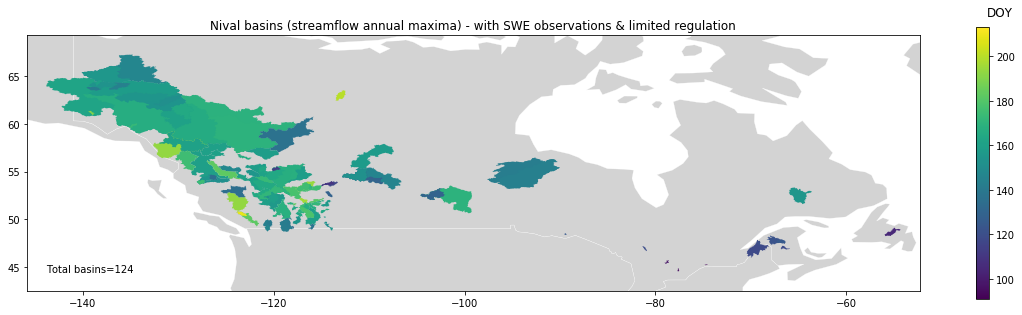

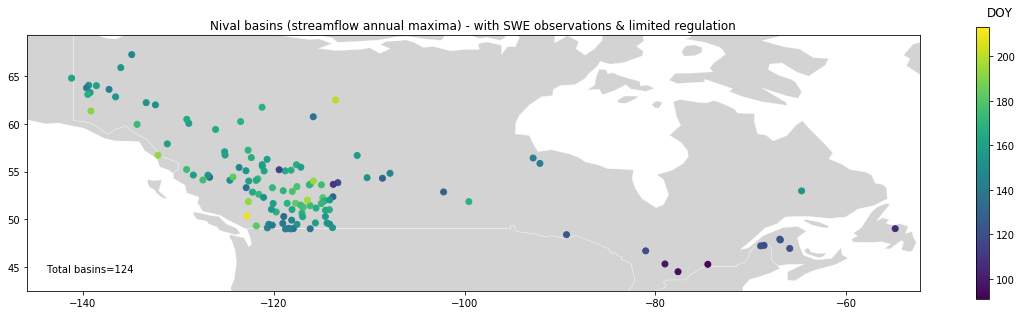

In [56]:
# Plot nival basins on map
basins_maps(nival_basins_annualmax_withswe_RHBN, method='streamflow annual maxima', title_end=' - with SWE observations & limited regulation', colours_column='doy', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

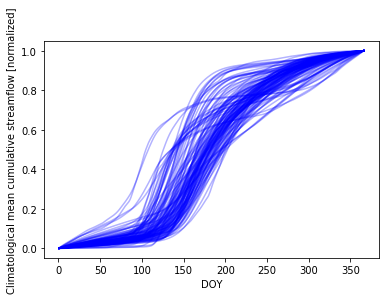

In [57]:
# Plot hydrographs for all identified basins
cumulative_hydrographs(nival_basins_annualmax_withswe_RHBN, streamflow_obs_path, flag=0)

### Based on streamflow POT
We can now sub-select nival basins identified based on streamflow POT that meet the SWE stations criteria and with limited regulation.

In [58]:
# Extract only nival basins with SWE observations & limited regulation
nival_RHBN_basins_POT = set.intersection(set(RHBN_stations['STATION_NUMBER'].values), set(nival_basins_POT_withswe.index.values))
nival_basins_POT_withswe_RHBN = nival_basins_POT_withswe.loc[nival_RHBN_basins_POT]

print("Based on streamflow POT: There are "+str(len(nival_basins_POT_withswe_RHBN.index))+" nival basins with SWE observations & limited regulation")

Based on streamflow POT: There are 117 nival basins with SWE observations & limited regulation


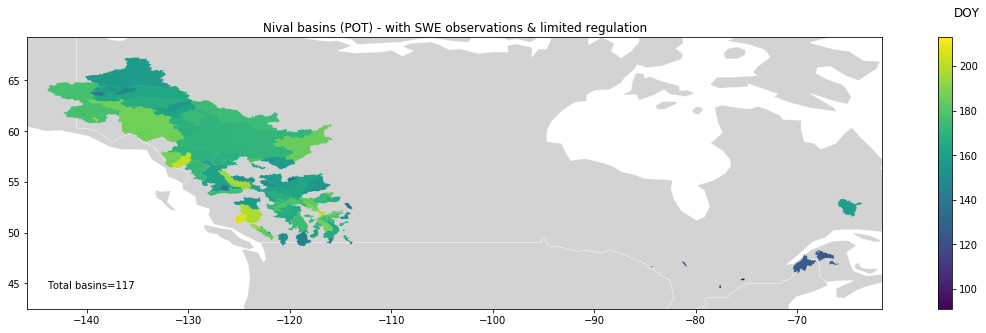

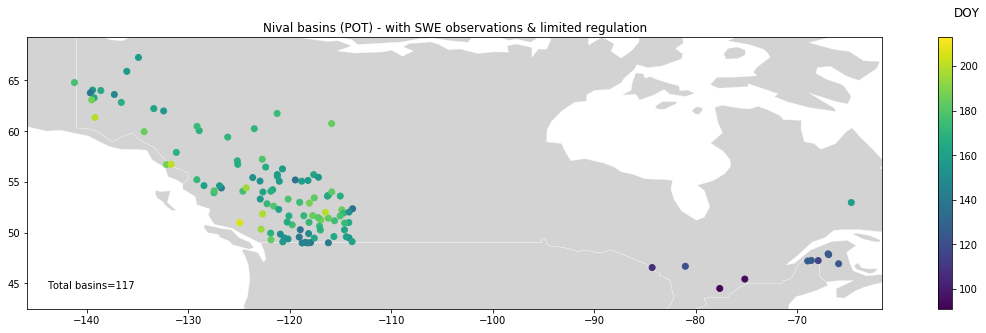

In [59]:
# Plot nival basins on map
basins_maps(nival_basins_POT_withswe_RHBN, method='POT', title_end=' - with SWE observations & limited regulation', colours_column='doy', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

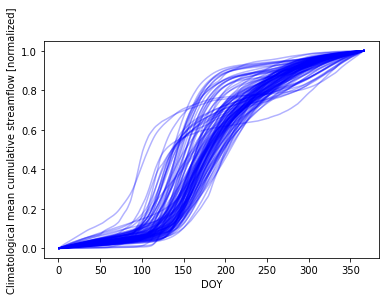

In [60]:
# Plot hydrographs for all identified basins
cumulative_hydrographs(nival_basins_POT_withswe_RHBN, streamflow_obs_path, flag=0)

### Based on streamflow COM
We can now sub-select nival basins identified based on streamflow COM that meet the SWE stations criteria and with limited regulation.

In [61]:
# Extract only nival basins with SWE observations & limited regulation
nival_RHBN_basins_COM = set.intersection(set(RHBN_stations['STATION_NUMBER'].values), set(nival_basins_COM_withswe.index.values))
nival_basins_COM_withswe_RHBN = nival_basins_COM_withswe.loc[nival_RHBN_basins_COM]

print("Based on streamflow COM: There are "+str(len(nival_basins_COM_withswe_RHBN.index))+" nival basins with SWE observations & limited regulation")

Based on streamflow COM: There are 137 nival basins with SWE observations & limited regulation


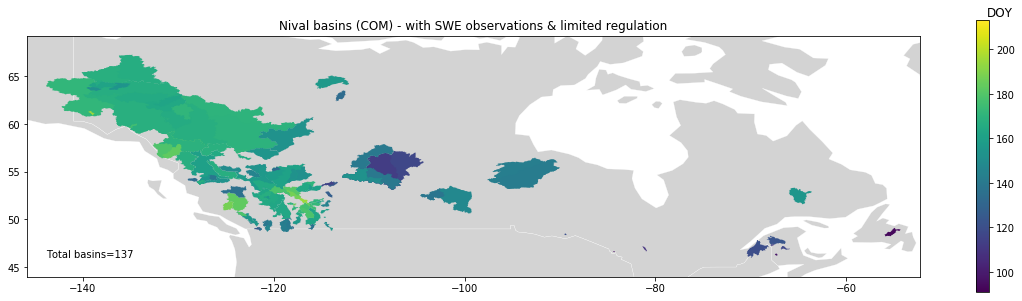

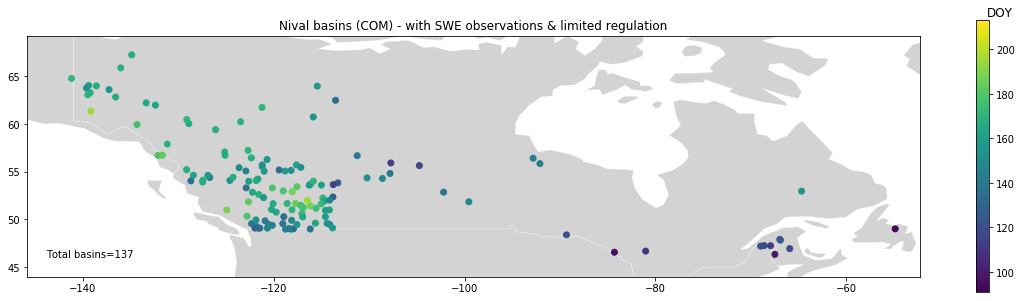

In [62]:
# Plot nival basins on map
basins_maps(nival_basins_COM_withswe_RHBN, method='COM', title_end=' - with SWE observations & limited regulation', colours_column='doy', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

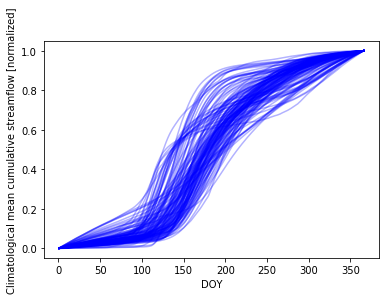

In [63]:
# Plot hydrographs for all identified basins
cumulative_hydrographs(nival_basins_COM_withswe_RHBN, streamflow_obs_path, flag=0)

# Extract overlapping basins for 3 methods
We now extract all nival basins (with SWE stations criteria & limited regulation) that appear in all 3 lists, based on: streamflow annual maxima, POT & COM. Because each method has its limitations, selecting basins that were consistently picked up by all 3 methods gives us some added confidence.

In [70]:
# Extract nival basins with SWE observations & limited regulation identified by all 3 methods
overlapping_nival_basins = set.intersection(set(nival_basins_annualmax_withswe_RHBN.index.values), set(nival_basins_COM_withswe_RHBN.index.values), set(nival_basins_POT_withswe_RHBN.index.values))
overlapping_nival_basins_withswe_RHBN = nival_basins_annualmax_withswe_RHBN.loc[overlapping_nival_basins]

print("Based on all 3 methods: There are "+str(len(overlapping_nival_basins_withswe_RHBN.index))+" nival basins with SWE observations & limited regulation")

Based on all 3 methods: There are 108 nival basins with SWE observations & limited regulation


In [71]:
# Re-organize the dataset to save circular statistics from all 3 methods

# rename the circular statistics from streamflow annual maxima - these are the ones that were automatically added to the dataset (see cell above)
overlapping_nival_basins_withswe_RHBN = overlapping_nival_basins_withswe_RHBN.rename(columns={"theta_rad": "theta_rad_Qmax", "regularity": "regularity_Qmax", "doy": "doy_Qmax", })

# add the circular statistics from streamflow POT
overlapping_nival_basins_withswe_RHBN['theta_rad_QPOT'] = nival_basins_POT_withswe_RHBN['theta_rad'][overlapping_nival_basins_withswe_RHBN.index]
overlapping_nival_basins_withswe_RHBN['regularity_QPOT'] = nival_basins_POT_withswe_RHBN['regularity'][overlapping_nival_basins_withswe_RHBN.index]
overlapping_nival_basins_withswe_RHBN['doy_QPOT'] = nival_basins_POT_withswe_RHBN['doy'][overlapping_nival_basins_withswe_RHBN.index]

# add the circular statistics from streamflow COM
overlapping_nival_basins_withswe_RHBN['theta_rad_QCOM'] = nival_basins_COM_withswe_RHBN['theta_rad'][overlapping_nival_basins_withswe_RHBN.index]
overlapping_nival_basins_withswe_RHBN['regularity_QCOM'] = nival_basins_COM_withswe_RHBN['regularity'][overlapping_nival_basins_withswe_RHBN.index]
overlapping_nival_basins_withswe_RHBN['doy_QCOM'] = nival_basins_COM_withswe_RHBN['doy'][overlapping_nival_basins_withswe_RHBN.index]

display(overlapping_nival_basins_withswe_RHBN.head())

,StationNam,Stn_UID,Shp_Area,Shp_Perime,geometry,HydexArea,outlet_lat,outlet_lon,theta_rad_Qmax,regularity_Qmax,doy_Qmax,theta_rad_QPOT,regularity_QPOT,doy_QPOT,theta_rad_QCOM,regularity_QCOM,doy_QCOM
08NN019,TRAPPING CREEK NEAR THE MOUTH,08NN019_1,144.940994,65.464500,"POLYGON Z ((-118.92118 49.62852 0.00000, -118....",None,49.565369,-119.051964,2.414014,0.978466,140.331394,2.409199,0.965903,140.054169,2.380729,0.989313,138.395772
02CF011,VERMILION RIVER NEAR VAL CARON,02CF011_1,680.428896,246.010718,"POLYGON Z ((-81.26806 47.18079 0.00000, -81.26...",NaN,46.685440,-81.009247,2.063384,0.873897,119.941359,2.090149,0.908809,121.502484,1.879014,0.959211,109.225737
09BC001,PELLY RIVER AT PELLY CROSSING,09BC001_1,48866.506584,1751.520931,"POLYGON Z ((-136.24838 62.98264 0.00000, -136....",NaN,62.829720,-136.580566,2.656005,0.986710,154.391729,2.875047,0.914466,167.148414,2.836185,0.993273,164.867696
10AA001,LIARD RIVER AT UPPER CROSSING,10AA001_1,32556.149618,1316.243263,"POLYGON Z ((-129.63259 59.75348 0.00000, -129....",NaN,60.050831,-128.906937,2.765324,0.986242,160.750440,2.894799,0.964865,168.300392,2.848435,0.993181,165.581262
10ED001,LIARD RIVER AT FORT LIARD,10ED001_1,218808.376684,4289.182453,"POLYGON Z ((-129.31822 62.17602 0.00000, -129....",NaN,60.241562,-123.475418,2.910000,0.957595,169.172829,2.938497,0.925638,170.825805,2.912664,0.991727,169.326981


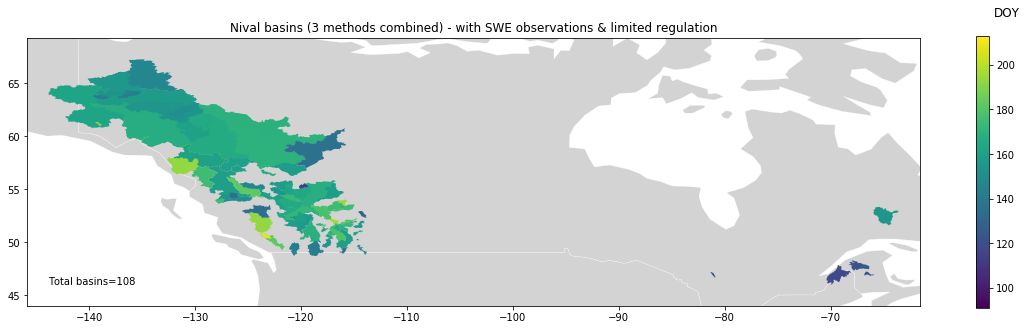

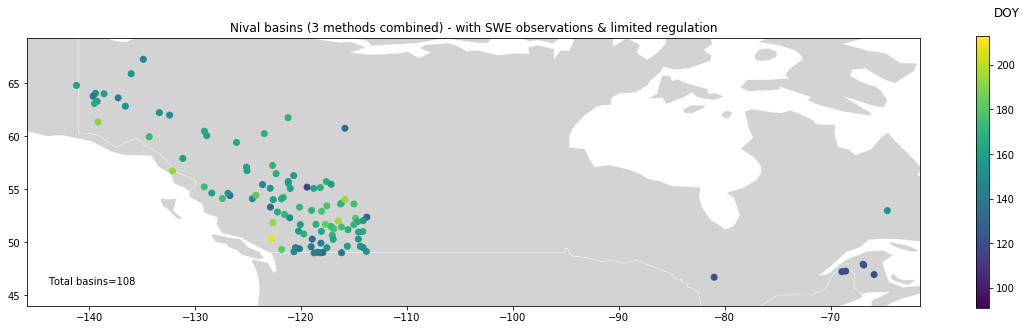

In [72]:
# Plot nival basins on map
# Note: the DOY used are from the annual streamflow maxima - any other could be used by replacing the string provided for the colours_column variable below  
basins_maps(overlapping_nival_basins_withswe_RHBN, method='3 methods combined', title_end=' - with SWE observations & limited regulation', colours_column='doy_Qmax', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

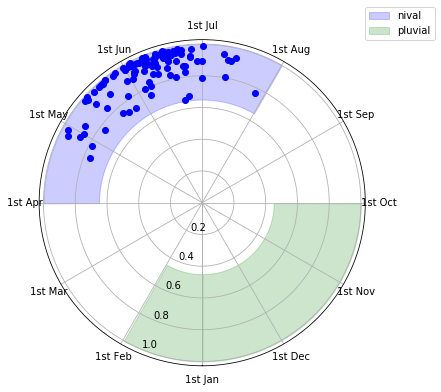

In [73]:
# Create polar plot
# Note: again here we use the annual streamflow maxima circular statistics for plotting - any other could be used by replacing the strings provided for theta_rad & regularity below
polar_plot(overlapping_nival_basins_withswe_RHBN['theta_rad_Qmax'].values, overlapping_nival_basins_withswe_RHBN['regularity_Qmax'].values, flag=1, nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default, nival_regularity_threshold=nival_regularity_threshold_default)

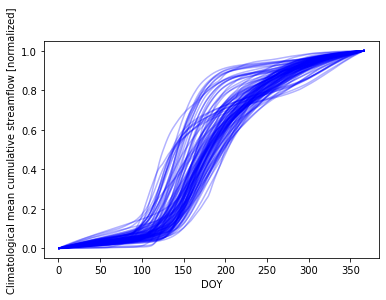

In [74]:
# Plot hydrographs for all identified basins
cumulative_hydrographs(overlapping_nival_basins_withswe_RHBN, streamflow_obs_path, flag=0)

# Identify glacial basins
We need to identify basins that are dominantly glacial within this dataset, as this involves a different streamflow generation process. We identify these basins as having their peak DOY at or after a pre-defined date (set in user-defined variables at the top of the Notebook).

In [79]:
# Extract basins with a DOY >= 182 (for at least one of these 3 methods)
glacial_basins = overlapping_nival_basins_withswe_RHBN[(overlapping_nival_basins_withswe_RHBN.doy_Qmax>=glacial_min_doy_default) | (overlapping_nival_basins_withswe_RHBN.doy_QPOT>=glacial_min_doy_default) | (overlapping_nival_basins_withswe_RHBN.doy_QCOM>=glacial_min_doy_default)]

display(glacial_basins)

,StationNam,Stn_UID,Shp_Area,Shp_Perime,geometry,HydexArea,outlet_lat,outlet_lon,theta_rad_Qmax,regularity_Qmax,doy_Qmax,theta_rad_QPOT,regularity_QPOT,doy_QPOT,theta_rad_QCOM,regularity_QCOM,doy_QCOM
08MG005,LILLOOET RIVER NEAR PEMBERTON,08MG005_1,2098.120117,301.782990,"POLYGON Z ((-122.85665 50.34583 0.00000, -122....",None,50.336021,-122.800247,3.591638,0.770195,208.782661,3.359641,0.875686,195.302406,3.076870,0.991679,178.864796
08NA002,COLUMBIA RIVER AT NICHOLSON,08NA002_1,6663.680176,525.593994,"POLYGON Z ((-116.91302 51.24232 0.00000, -116....",None,51.243561,-116.912933,3.071921,0.973063,178.569195,3.217089,0.931237,187.013515,3.070411,0.994102,178.481997
07OB001,HAY RIVER NEAR HAY RIVER,07OB001_1,51382.997725,1909.604358,"POLYGON Z ((-115.85316 60.74405 0.00000, -115....",NaN,60.743000,-115.859642,2.356733,0.847923,136.988633,3.173721,0.690953,184.480727,2.632938,0.947539,153.056362
07AD002,ATHABASCA RIVER AT HINTON,07AD002_1,9764.773680,741.084659,"POLYGON Z ((-118.98277 53.48083 0.00000, -118....",NaN,53.424290,-117.569420,3.059049,0.930060,177.826954,3.132201,0.939529,182.081378,3.116930,0.996135,181.189218
08MG013,HARRISON RIVER NEAR HARRISON HOT SPRINGS,08MG013_1,7885.839844,856.663025,"POLYGON Z ((-121.83028 49.29231 0.00000, -121....",None,49.300419,-121.829643,3.139308,0.783842,182.462029,3.151294,0.828439,183.196619,2.668657,0.984205,155.137249
07AG004,MCLEOD RIVER NEAR WHITECOURT,07AG004_1,9108.998403,587.463971,"POLYGON Z ((-115.83840 54.01159 0.00000, -115....",NaN,54.012451,-115.839729,3.339556,0.908818,194.000000,3.142507,0.924181,182.649830,2.935022,0.890028,170.500000
05BA001,BOW RIVER AT LAKE LOUISE,05BA001_1,422.433422,124.571480,"POLYGON Z ((-116.45854 51.72693 0.00000, -116....",NaN,51.428600,-116.188942,3.002836,0.946668,174.544287,3.151727,0.945890,183.232357,3.205618,0.993755,186.329078
09CA004,DUKE RIVER NEAR THE MOUTH,09CA004_1,654.044932,160.196135,"POLYGON Z ((-139.18793 61.34884 0.00000, -139....",NaN,61.346001,-139.167923,3.283328,0.949301,190.846407,3.433088,0.922665,199.577250,3.354391,0.987065,194.978304
08JE001,STUART RIVER NEAR FORT ST. JAMES,08JE001_1,14212.400391,1131.329956,"POLYGON Z ((-124.51266 55.04857 0.00000, -124....",None,54.416859,-124.270622,3.147015,0.988692,182.942958,3.367311,0.841393,195.746055,2.883597,0.970535,167.633544
08MB005,CHILCOTIN RIVER BELOW BIG CREEK,08MB005_1,19205.500000,986.815002,"POLYGON Z ((-122.67186 51.84043 0.00000, -122....",None,51.847939,-122.654778,3.320290,0.913791,193.028007,3.409536,0.923378,198.213693,3.148378,0.995059,183.026487


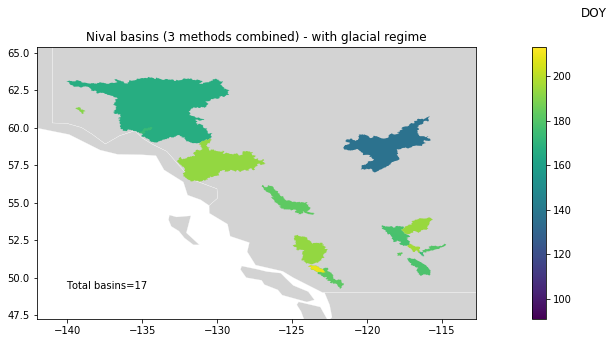

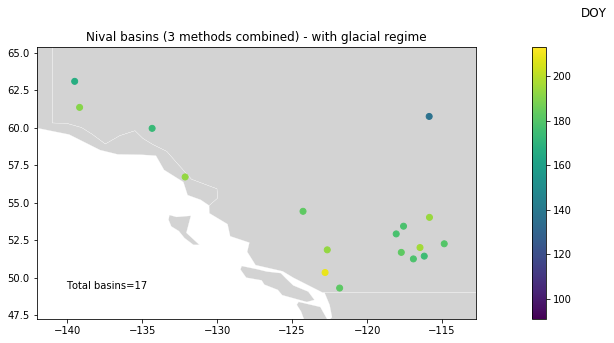

In [80]:
# Plot glacial basins on map
# Note: the DOY used are from the annual streamflow maxima - any other could be used by replacing the string provided for the colours_column variable below  
basins_maps(glacial_basins, method='3 methods combined', title_end=' - with glacial regime', colours_column='doy_Qmax', nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default)

In [81]:
# Add regime column to the dataset with a 'glacial' identifier for those basins
overlapping_nival_basins_withswe_RHBN['regime'] = np.nan
overlapping_nival_basins_withswe_RHBN['regime'].loc[glacial_basins.index] = ['glacial']*len(glacial_basins.index)

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


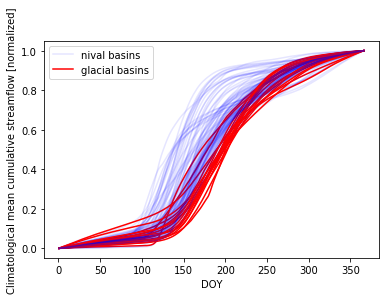

In [82]:
# Plot hydrographs for all identified basins
cumulative_hydrographs(overlapping_nival_basins_withswe_RHBN, streamflow_obs_path, flag=1)

A fun exercise: We expect to see more variability between years for a nival basin. Glacial basins have a very small inter-annual variability in comparison. We plot cumulative hydrographs for a selected glacial and a nival basin to check this.

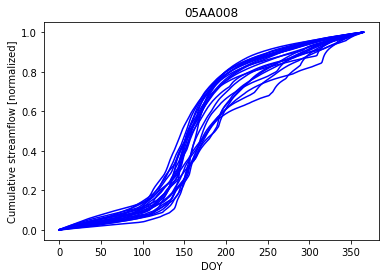

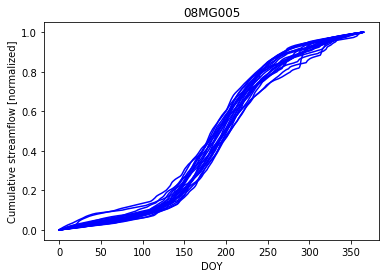

In [83]:
# Plot several years' hydrographs for a glacial and a nival basin

# define the test basins to be used
testcase_nival_basinid = '05AA008' # CROWSNEST RIVER AT FRANK
testcase_glacial_basinid = '08MG005' # LILLOOET RIVER NEAR PEMBERTON

years_to_plot_start, years_to_plot_end  = 1990, 2010

# we expect to see RuntimeWarnings in this block due to missing values
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    for b in [testcase_nival_basinid, testcase_glacial_basinid]:
        
        plt.figure()
        
        # open streamflow observations data
        streamflow_data_ds = xr.open_dataset(streamflow_obs_path+"HYDAT_"+b[0:2]+".nc")
        streamflow_data_ds = streamflow_data_ds.set_index({"Station_ID":"Station_ID"})
        streamflow_data_ds = streamflow_data_ds.rename({"n":'Station_ID'})
        
        # extract streamflow data for a few years
        flow_data = streamflow_data_ds.where(streamflow_data_ds.Station_ID==b, drop=True).Flow.sel(time=slice(str(years_to_plot_start)+'-01-01', str(years_to_plot_end)+'-12-31'))
        
        # looping over years to plot
        for y in range(years_to_plot_start, years_to_plot_end+1):
            
            # calculate the normalized cumulative sum for year y - we normalize so that all basins hydrographs can be plotted on a single plot 
            norm_cumsum = flow_data.sel(time=str(y)).cumsum() / flow_data.sel(time=str(y)).cumsum().values[0][-1]
            
            # plotting
            plt.plot(np.arange(len(norm_cumsum.values[0])), norm_cumsum.values[0], color='b')
            
        plt.title(b)
        plt.ylabel('Cumulative streamflow [normalized]')
        plt.xlabel('DOY')

# Store data
This can then be read in this Notebook or called in any other Notebook of this workflow without having to re-run everything each single time. To read the stored data use: %store -r dataset_name

In [84]:
%store overlapping_nival_basins_withswe_RHBN

Stored 'overlapping_nival_basins_withswe_RHBN' (GeoDataFrame)
